# Assignment 4:  Active Learning and Cost-Effective Labeling

## Task 1

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Loading the MNIST dataset using Hugging Face Datasets library
from datasets import load_dataset

# Load the MNIST dataset
mnist = load_dataset('mnist')

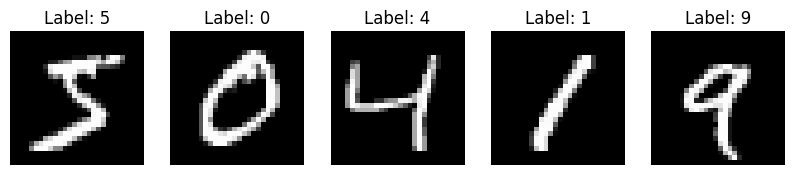

In [3]:
# Display a few images from the dataset
import matplotlib.pyplot as plt

# Display the first 10 images from the dataset with their labels
fig, axs = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    axs[i].imshow(mnist['train']['image'][i], cmap='gray')
    axs[i].set_title(f'Label: {mnist["train"]["label"][i]}')
    axs[i].axis('off')

plt.show()

In [4]:
# Convert the image data into Numpy arrays and normalize pixel values to the range [0,1]
import numpy as np

# Convert the image data into Numpy arrays
X_train = np.array(mnist['train']['image'])

# Normalize pixel values to the range [0,1]
X_train = X_train / 255.0

# Display the shape of the training data
print(X_train.shape)

(60000, 28, 28)


In [5]:
# Flatten into 784-dimensional vectors
X_train = X_train.reshape(-1, 784)

# Display the shape of the training data
print(X_train.shape)

(60000, 784)


In [6]:
# Randomly select an initially labeled dataset of 200 samples from training samples
n_initial = 200

# Set the random seed for reproducibility
np.random.seed(42)


# Randomly select 200 samples from the training set
initial_idx = np.random.choice(range(len(X_train)), size=n_initial, replace=False)

# Display the shape of the initially labeled samples
X_initial = X_train[initial_idx]
print(X_initial.shape)

# Display the indices of the initially labeled samples
print(initial_idx)

# Display labels of the initially labeled samples from the training set
y_initial = np.zeros(n_initial, dtype=int)
for i in range(n_initial):
    y_initial[i] = mnist["train"]["label"][initial_idx[i]]
print(y_initial)


(200, 784)
[12628 37730 39991  8525  8279 51012 14871 15127  9366 33322 53390 21819
  5026 23428 45297 26354 30195 47038 20731 34047 26064 42469 29746 14522
 31572 54949 19368  3803 53325 14300 51301  9008 47521 25224 48921 37978
 44171 26303 19458  5369 50291 25951 54908 56362 32218  2885 36559  8966
 46574 10530 44628   273 19269 36911 10121 13290 57606 47189 29209 42187
 25386 17005 10981 47313 27070  6685 54960 58125 40700 13902 31539 49716
 49519 51923  3502 39336  2218 18505 10689 21377  1866 20192 28870 52203
  3867  3222 21785 20984 48539 40694  8440  9951  1334 32572 28344 46503
 34482 36271 36874 11512 23847  9937 52122  9189 55990 11744 34545 13152
 13059 49858 52310  8914 42178  9199 37940 54184 48596 58585  8063 21052
 30487  7528  9935 31354 48001 49675 49979 34356 38895 46280  9073 24961
   476 16358 24839 24915 15359 16242 33821 31935 48297 25311  4402 52611
 27692 36474 33603 24219 41145 31168 31382 57527 48272 23534 45163  5874
 30088 59052 17179 45513 39996  8478 361

In [7]:
# Generate an "Unlabeled Pool," the Initial Dataset excluding 200 samples.

# Get the indices of the unlabeled pool
unlabeled_pool_idx = np.delete(np.arange(len(X_train)), initial_idx)

# Display the shape of the unlabeled pool
X_pool = X_train[unlabeled_pool_idx]
print(X_pool.shape)

(59800, 784)


## Task 2

## Task 3

Implementing Uncertainty Sampling for Active Learning (on the initial dataset of 200 samples)

In [8]:
from sklearn.ensemble import RandomForestClassifier

# Create a random forest classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the initially labeled dataset
classifier.fit(X_initial, y_initial)

RandomForestClassifier(random_state=42)

In [9]:
# Print initial accuracy

# Load the test set
X_test = np.array(mnist['test']['image'])
y_test = np.array(mnist['test']['label'])

# Print the shapes
print(X_test.shape)
print(y_test.shape)

# Normalize pixel values to the range [0,1]
X_test = X_test / 255.0
# Flatten into 784-dimensional vector
X_test = X_test.reshape(-1, 784)

# Calculate the initial accuracy
initial_accuracy = np.mean(classifier.predict(X_test) == y_test)
print(f'Initial accuracy: {initial_accuracy:.3f}')

(10000, 28, 28)
(10000,)
Initial accuracy: 0.812


In [10]:
# Active Learning Loop (20 iterations)
n_queries = 20

for i in range(n_queries):
    # Compute uncertainty (Label Entropy) for each sample in the unlabeled pool using entropy.
    uncertainty = -np.clip(classifier.predict_proba(X_pool), 1e-10, 1.0) * np.log(np.clip(classifier.predict_proba(X_pool), 1e-10, 1.0)) # Ensure probabilities are within [epsilon, 1]
    
    # Vector of uncertainties
    uncertainty = uncertainty.sum(axis=1)
    #print(uncertainty)
    #print(uncertainty.shape)
    print(f'Query {i + 1}/{n_queries}, Uncertainty: {uncertainty.mean():.3f}')

    # Select the sample with the highest uncertainty and query its true label.
    query_idx = np.argmax(uncertainty)

    # Add the queried sample to the labelled dataset.
    X_initial = np.vstack((X_initial, X_pool[query_idx]))
    y_initial = np.append(y_initial, mnist["train"]["label"][unlabeled_pool_idx[query_idx]])

    # Remove the queried sample from the unlabelled pool
    X_pool = np.delete(X_pool, query_idx, axis=0)

    # Print the queried index and the true label
    print(f'Query {i + 1}/{n_queries}, Queried Index: {unlabeled_pool_idx[query_idx]}, True Label: {mnist["train"]["label"][unlabeled_pool_idx[query_idx]]}')
    
    # Retrain the model and check the model's accuracy on the test set.
    classifier.fit(X_initial, y_initial)

    # Calculate the accuracy
    accuracy = classifier.score(X_test, y_test)
    print(f'Query {i + 1}/{n_queries}, Accuracy: {accuracy:.3f}')
    
    

Query 1/20, Uncertainty: 1.684
Query 1/20, Queried Index: 28803, True Label: 3
Query 1/20, Accuracy: 0.814
Query 2/20, Uncertainty: 1.691
Query 2/20, Queried Index: 24740, True Label: 8
Query 2/20, Accuracy: 0.814
Query 3/20, Uncertainty: 1.696
Query 3/20, Queried Index: 42307, True Label: 1
Query 3/20, Accuracy: 0.809
Query 4/20, Uncertainty: 1.706
Query 4/20, Queried Index: 39471, True Label: 4
Query 4/20, Accuracy: 0.809
Query 5/20, Uncertainty: 1.706
Query 5/20, Queried Index: 15815, True Label: 3
Query 5/20, Accuracy: 0.801
Query 6/20, Uncertainty: 1.710
Query 6/20, Queried Index: 2713, True Label: 5
Query 6/20, Accuracy: 0.816
Query 7/20, Uncertainty: 1.707
Query 7/20, Queried Index: 8925, True Label: 4
Query 7/20, Accuracy: 0.810
Query 8/20, Uncertainty: 1.705
Query 8/20, Queried Index: 15789, True Label: 1
Query 8/20, Accuracy: 0.812
Query 9/20, Uncertainty: 1.708
Query 9/20, Queried Index: 418, True Label: 8
Query 9/20, Accuracy: 0.811
Query 10/20, Uncertainty: 1.717
Query 10/